### Labor Market Outcomes for the College Educated

April 10, 2018

-------

Brian Dew, @bd_econ

In [1]:
# Preliminaries--load packages and settings
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
import pandas as pd
import numpy as np
import wquantiles

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]

In [2]:
# Consumer Price Index to adjust nominal prices
cpi = pd.read_csv('cpi.csv')
cpi.index = pd.to_datetime(cpi.DATE)

In [3]:
# Functions that get labor force data from the CPS and graph it
def get_cps_data(filters, calc_type, decile=0.5, rtype='share'):
    """Filter the database and calculate labor market stat"""
    data = pd.Series()
    for year in range(1994, 2019):
        d = pd.read_feather(f'data/cps_{year}.ft', nthreads=3)
        for month in range(1, 13):
            df = d[(d['HRMONTH'] == month)]
            if len(df) > 0:
                df = df.query(filters)
                if calc_type == 'epop':
                    empl = np.where(df['PREMPNOT']==1, 1, 0)
                    epop = np.average(empl, weights=df['PWSSWGT'])
                    data[pd.to_datetime(f'{year}-{month}-01')] = epop * 100
                if calc_type == 'unemp':
                    un = np.where(df['PREMPNOT']==2, 1, 0)
                    lf = np.where(df['PREMPNOT'].isin([1, 2]), 1, 0)
                    unrt = (df['PWSSWGT'] * un).sum() / (df['PWSSWGT'] * lf).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = unrt * 100
                if calc_type == 'lfpr':
                    lf = np.where(df['PREMPNOT'].isin([1, 2]), 1, 0)
                    unrt = (df['PWSSWGT'] * lf).sum() / (df['PWSSWGT']).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = unrt * 100
                # Following based on:
                # https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx
                if calc_type == 'disc':
                    dw = np.where(df['PEDWWNTO'].isin([1]), 1, 0)
                    if rtype == 'level':
                        dwrt = ((df['PWSSWGT'] / 100000000) * dw).sum() / 100
                    else:
                        dwrt = (df['PWSSWGT'] * dw).sum() / (df['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = dwrt 
                if calc_type == 'nilfsch':
                    ns = np.where((df['PRWNTJOB']==2) & (df['PENLFACT']==3), 1, 0)
                    if rtype == 'level':
                        scrt = ((df['PWSSWGT'] / 100000000) * ns).sum() / 100
                    else:
                        scrt = (df['PWSSWGT'] * ns).sum() / (df['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = scrt
                if calc_type == 'disill':
                    nd = np.where(((df['PRWNTJOB']==2) & 
                                   ((df['PEMLR']==6) | 
                                    (df['PENLFACT']==1) | 
                                    (df['PENLFACT']==2))), 1, 0)
                    if rtype == 'level':
                        di = ((df['PWSSWGT'] / 100000000) * nd).sum() / 100
                    else:                    
                        di = (df['PWSSWGT'] * nd).sum() / (df['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = di
                if calc_type == 'care':
                    care = np.where((df['PRWNTJOB']==2) & (df['PENLFACT']==4), 1, 0)
                    if rtype == 'level':
                        ncare = ((df['PWSSWGT'] / 100000000) * care).sum() / 100
                    else:                      
                        ncare = (df['PWSSWGT'] * care).sum() / (df['PWSSWGT']).sum() * 100 
                    data[pd.to_datetime(f'{year}-{month}-01')] = ncare
                if calc_type in ['uwe', 'uwe_gr', 'uwe_r']:
                    uwe = wquantiles.quantile(
                        df['PRERNWA'], df['PWORWGT'].astype(float), decile) / 100.0
                    data[pd.to_datetime(f'{year}-{month}-01')] = uwe
                if calc_type in ['uhe', 'uhe_gr', 'uhe_r']:
                    uhe = wquantiles.quantile(
                        df['PRERNHLY'], df['PWORWGT'].astype(float), decile) / 100.0
                    data[pd.to_datetime(f'{year}-{month}-01')] = uhe
        if calc_type in ['quwe_r', 'quwe']:
            for q in [('Q1', [1, 2, 3]), ('Q2', [4, 5, 6]), ('Q3', [7, 8, 9]), ('Q4', [10, 11, 12])]:
                df = d[(d['HRMONTH'].isin(q[1]))]
                if len(df['HRMONTH'].unique()) > 2:
                    df = df.query(filters)
                    quwe = wquantiles.quantile(
                        df['PRERNWA'], df['PWORWGT'].astype(float), decile) / 100.0
                    data[pd.to_datetime(f'{year}-{q[0]}')] = quwe
    # Growth if wage series
    if calc_type in ['uwe_gr', 'uhe_gr']:
        data = data.pct_change(12) * 100
    
    # Price adjustment for real wage series
    if calc_type in ['uwe_r', 'uhe_r', 'quwe_r']:
        data = pd.concat([data, cpi['CPIAUCSL']], axis=1)
        data = (data[0] * data['CPIAUCSL'].iloc[-1]) / data['CPIAUCSL']
        
    if calc_type not in ['quwe_r', 'quwe']:
        data = data.rolling(12).mean().dropna()
    
    # Take one-year moving average to smooth out seasonality and noise
    return data.dropna()

def labor_mkt_grapher(title, data, color):
    """Graph the labor market! """
    spcr, spcr2 = (data.max() - data.min()) / 18, (data.max() - data.min()) / 40
    ax = data.plot(title=title, figsize=(5, 2.5), color=color)
    ax = plt.scatter([data.index[-1]], [data[-1]], color=color, s=25)
    for i, v in rec_dt:
        ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.2)  
    ax = plt.annotate(f'  {data[-1]: .1f}', (data.index[-1], data[-1]-spcr2))
    ax = plt.annotate(f'{data.index[-1]:%b %Y}', (data.index[-1], data[-1]+spcr), 
                      fontweight='bold')
    ax = plt.xlabel('Source: Current Population Survey')

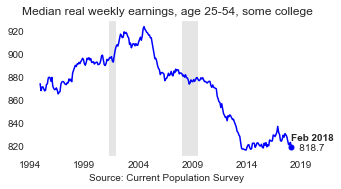

In [7]:
# Real median weekly earnings
filters = 'PEEDUCA > 40 and PEEDUCA < 43 and PRTAGE > 24 and PRTAGE < 55 and PRERNWA > 0 and PRFTLF == 1'
calc_type = 'uwe_r'
title = 'Median real weekly earnings, age 25-54, some college'
data = get_cps_data(filters, calc_type, decile=0.5)
labor_mkt_grapher(title, data, 'blue')

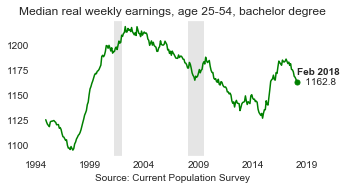

In [8]:
# Real median weekly earnings
filters = 'PEEDUCA == 43 and PRTAGE > 24 and PRTAGE < 55 and PRERNWA > 0 and PRFTLF == 1'
calc_type = 'uwe_r'
title = 'Median real weekly earnings, age 25-54, bachelor degree'
data = get_cps_data(filters, calc_type, decile=0.5)
labor_mkt_grapher(title, data, 'green')

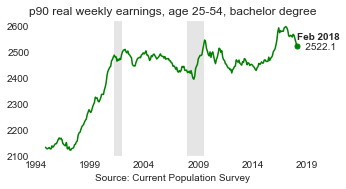

In [13]:
# Real p90 weekly earnings
filters = 'PEEDUCA == 43 and PRTAGE > 24 and PRTAGE < 55 and PRERNWA > 0 and PRFTLF == 1'
calc_type = 'uwe_r'
title = 'p90 real weekly earnings, age 25-54, bachelor degree'
data = get_cps_data(filters, calc_type, decile=0.9)
labor_mkt_grapher(title, data, 'green')

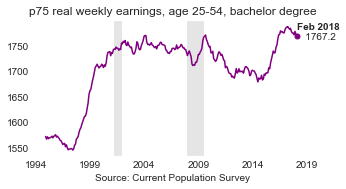

In [11]:
# Real p25 weekly earnings
filters = 'PEEDUCA == 43 and PRTAGE > 24 and PRTAGE < 55 and PRERNWA > 0 and PRFTLF == 1'
calc_type = 'uwe_r'
title = 'p75 real weekly earnings, age 25-54, bachelor degree'
data = get_cps_data(filters, calc_type, decile=0.75)
labor_mkt_grapher(title, data, 'purple')